In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

#Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("darkgrid")

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import collections
from lightgbm import LGBMClassifier



from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


pd.set_option("display.max_columns", 999)
pd.get_option("display.max_columns")

pd.set_option("display.max_rows", 999)
pd.get_option("display.max_rows")

%matplotlib inline

In [3]:
df = pd.read_csv("churn_data_modelling.csv")
df.head()

,AgentRefID,max_amount_transaction,min_amount_transaction,avg_amount_transaction,median_amount_transaction,total_amount_transaction_credit,total_unique_distributer,avg_amout_payment_gt100_permonth,avg_txn_first_week,avg_last_month_1week_amount_txn,vintage,total_ticket_raised_last_2_month,avg_ticked_rasied_per_month,Churn,Total_Score
0,1,100.0,1.0,11.714286,2.0,8.0,1,100.000000,1.333333,0.0,156.0,0.0,0.000000,0.0,10
1,55,25000.0,1.0,7000.000000,4999.0,43.0,1,11878.973459,5923.153846,0.0,56.0,0.0,0.000000,1.0,7
2,83,25000.0,1.0,2254.882877,1950.0,930.0,1,2784.038428,2140.512927,0.0,203.0,0.0,1.000000,0.0,3
3,180,25000.0,1.0,3157.239617,2000.0,22.0,1,2946.772422,3118.101190,23500.0,202.0,0.0,2.333333,0.0,4
4,29,25000.0,1.0,2243.319098,2000.0,164.0,1,2754.329794,2148.735000,68861.0,203.0,0.0,1.000000,0.0,3


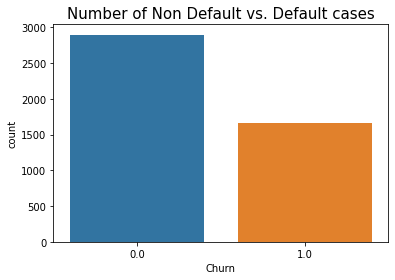

In [5]:
#Churn vs. Non-Churn
sns.countplot('Churn', data=df)
plt.title('Number of Non Default vs. Default cases', fontsize = 15);

In [6]:
print('Percentage of No Churns: {}%'.format(round(df.Churn.value_counts()[0]/len(df) * 100.0,2)))
print('Percentage of Churn: {}%'.format(round(df.Churn.value_counts()[1]/len(df) * 100.0,2)))

Percentage of No Churns: 63.55%
Percentage of Churn: 36.45%


In [11]:
corr_dict = dict()
for col in df.columns:
    if col not in ["Churn", "AgentRefID"]:
        corr_score = df[col].corr(df.Churn, method="spearman")
        if abs(corr_score) >=0.05:
            corr_dict[col] = corr_score
sorted_dict = {k: v for k, v in sorted(corr_dict.items(), key=lambda item:item[1])}
sorted_dict

{'Total_Score': 0.5928007378823636,
 'avg_amount_transaction': -0.07866438325527357,
 'avg_last_month_1week_amount_txn': -0.5724433345778658,
 'avg_txn_first_week': -0.2645448972065566,
 'max_amount_transaction': -0.29753497016698255,
 'median_amount_transaction': -0.08143250806772119,
 'min_amount_transaction': 0.18784797858232571,
 'total_amount_transaction_credit': -0.35921308161668414,
 'total_ticket_raised_last_2_month': -0.09060521477781103,
 'total_unique_distributer': -0.09942332210398672,
 'vintage': -0.5341442039764839}

In [12]:
col_from_EDA = list(sorted_dict.keys())

In [13]:
col_from_EDA.append("AgentRefID")
col_from_EDA.append("Churn")

In [14]:
df = df[col_from_EDA]

In [15]:
df.isnull().sum()

avg_last_month_1week_amount_txn     0
vintage                             0
total_amount_transaction_credit     0
max_amount_transaction              0
avg_txn_first_week                  0
total_unique_distributer            0
total_ticket_raised_last_2_month    0
median_amount_transaction           0
avg_amount_transaction              0
min_amount_transaction              0
Total_Score                         0
AgentRefID                          0
Churn                               0
dtype: int64

In [16]:
# independent and depandant feature split
X = df.drop('Churn', axis=1)
y = df['Churn']


In [17]:
X = X.drop("AgentRefID", axis=1)

In [18]:
#Split the data using train-test split 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(3648, 11)

In [20]:
X_test.shape

(912, 11)

In [21]:
df_stand = df.copy()
# data standardization with  sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = X_train_stand.columns

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    #scale = StandardScaler()
    scale = MinMaxScaler(feature_range = (0, 1))
    
    # transform the training data column
    X_train_stand[i] = scale.fit_transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])
    #test_df_copy[i] = scale.transform(test_df[[i]])
    df_stand[i] = scale.transform(df_stand[[i]])

In [22]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train_stand.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape)) 
  
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0))) 

Before OverSampling, the shape of train_X: (3648, 11)
Before OverSampling, the shape of train_y: (3648,) 

Before OverSampling, counts of label '1': 1329
Before OverSampling, counts of label '0': 2319


In [23]:
# SMOTE OVERSAMPLING
sm = SMOTE(random_state = 2) 
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train_stand, y_train.ravel()) 

In [24]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_SMOTE.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_SMOTE.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_SMOTE == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_SMOTE == 0))) 

After OverSampling, the shape of train_X: (4638, 11)
After OverSampling, the shape of train_y: (4638,) 

After OverSampling, counts of label '1': 2319
After OverSampling, counts of label '0': 2319


In [25]:
#Convert to arrays to feed to the classifications algorithms
classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',n_jobs=-1),
    "Support Vector Classifier": LinearSVC(class_weight='balanced',dual=False, random_state=0),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', max_depth=3),
    "RandomForest":RandomForestClassifier(class_weight='balanced_subsample',max_depth = 4, n_jobs=-1),
    "Gradient Boosting":GradientBoostingClassifier(max_depth =3, n_estimators=10)
}

In [26]:
#Calculate the cross-validation score for each classifier 8;24
print('Cross-Validation Scores:-')
for key, classifier in classifiers.items():
        classifier.fit(X_train_stand, y_train)
        cv_score = cross_val_score(classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='accuracy',n_jobs=-1)
        precision = cross_val_score(classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='precision',n_jobs=-1)
        recall = cross_val_score(classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='recall',n_jobs=-1)
        auc = cross_val_score(classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='roc_auc',n_jobs=-1)
        print('{}: {} : {} : {} : {}'.format(key,round(cv_score.mean()*100.0, 2),
                                     round(recall.mean()*100.0, 2),
                                     round(precision.mean()*100.0, 2),
                                     round(auc.mean()*100.0, 2),))
    

Cross-Validation Scores:-
Logistic Regression: 77.75 : 78.4 : 77.62 : 86.1
Support Vector Classifier: 77.96 : 79.17 : 77.55 : 86.33
Decision Tree: 80.68 : 88.53 : 76.09 : 87.1
RandomForest: 81.11 : 88.27 : 77.63 : 88.53
Gradient Boosting: 80.81 : 88.23 : 76.81 : 88.47


In [27]:
 params = {
    "Logistic Regression": {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    "Support Vector Classifier": {'C': [0.5, 0.7, 0.9, 1]},
    "Decision Tree": {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))},
     "RandomForest": {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))},
     "Gradient Boosting":{
     "learning_rate"    : [0.05, 0.10, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5]
     }

}

In [28]:
#Using Grid search for finding the most optimal hyperparameters
def randomsearch(classifier, params):
    k = StratifiedKFold(n_splits=10)
    grid_classifier = RandomizedSearchCV(classifier, params, cv = k, n_jobs=-1)
    grid_classifier.fit(X_train_SMOTE, y_train_SMOTE)
    best_classifier = grid_classifier.best_estimator_
    return best_classifier

In [29]:
#Scores after applying Grid Search
hyperparameter_tuned_classfier = dict()
print('Cross-Validation Scores after applying RandomSearch:-')
for key, classifier in classifiers.items():
    tuned_classifier = randomsearch(classifier,params[key])
    hyperparameter_tuned_classfier[key] =tuned_classifier
    cv_score = cross_val_score(tuned_classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='accuracy',n_jobs=-1)
    precision = cross_val_score(tuned_classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='precision',n_jobs=-1)
    recall = cross_val_score(tuned_classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='recall',n_jobs=-1)
    auc = cross_val_score(tuned_classifier, X_train_SMOTE, y_train_SMOTE, cv=StratifiedKFold(shuffle = True),scoring='roc_auc',n_jobs=-1)
    print('{}: {} : {} : {} : {}'.format(key,round(cv_score.mean()*100.0, 2),
                                     round(recall.mean()*100.0, 2),
                                     round(precision.mean()*100.0, 2),
                                     round(auc.mean()*100.0, 2),))

Cross-Validation Scores after applying RandomSearch:-
Logistic Regression: 78.93 : 82.06 : 77.1 : 87.04
Support Vector Classifier: 77.88 : 78.87 : 77.26 : 86.28
Decision Tree: 80.55 : 89.22 : 76.38 : 86.85
RandomForest: 80.55 : 87.93 : 77.09 : 87.9
Gradient Boosting: 82.23 : 87.06 : 79.94 : 90.14


In [30]:
# LightGradient Boosting
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import gc
lgb_X_train_stand = X_train_stand.copy()
lgb_X_train_stand["TARGET"] = y_train
folds = StratifiedKFold(n_splits= 10, shuffle=True, random_state=2020)
sub_preds = np.zeros(lgb_X_train_stand.shape[0])
feats = [f for f in lgb_X_train_stand.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(lgb_X_train_stand[feats], lgb_X_train_stand['TARGET'])):
    train_x, train_y = lgb_X_train_stand[feats].iloc[train_idx], lgb_X_train_stand['TARGET'].iloc[train_idx]
    valid_x, valid_y = lgb_X_train_stand[feats].iloc[valid_idx], lgb_X_train_stand['TARGET'].iloc[valid_idx]

    lgb = LGBMClassifier(n_estimators=1000, learning_rate=0.02, num_leaves=45, class_weight='balanced',
        colsample_bytree=0.85, max_depth=8, bagging_fraction=0.4,
        min_split_gain=0.022, min_child_weight=40, reg_alpha=0.04, reg_lambda=0.07,silent=-1, verbose=-1)

    lgb.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 100)

    sub_preds += lgb.predict_proba(lgb_X_train_stand[feats], num_iteration=lgb.best_iteration_)[:, 1] / folds.n_splits

    del train_x, train_y, valid_x, valid_y
    gc.collect()

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.882499	training's binary_logloss: 0.676376	valid_1's auc: 0.877285	valid_1's binary_logloss: 0.676789
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	training's auc: 0.896083	training's binary_logloss: 0.454144	valid_1's auc: 0.888142	valid_1's binary_logloss: 0.462037
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.904006	training's binary_logloss: 0.391429	valid_1's auc: 0.86847	valid_1's binary_logloss: 0.444658
Early stopping, best iteration is:
[141]	training's auc: 0.901365	training's binary_logloss: 0.401652	valid_1's auc: 0.869312	valid_1's binary_logloss: 0.446559
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.902788	training's binary_logloss: 0.395252	valid_1's auc: 0.885857	valid_1's binary_logloss: 0.421291
Early stopping, b

In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    #plt.figure()
    plt.title(title)
    if ylim is not None:
        ax.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

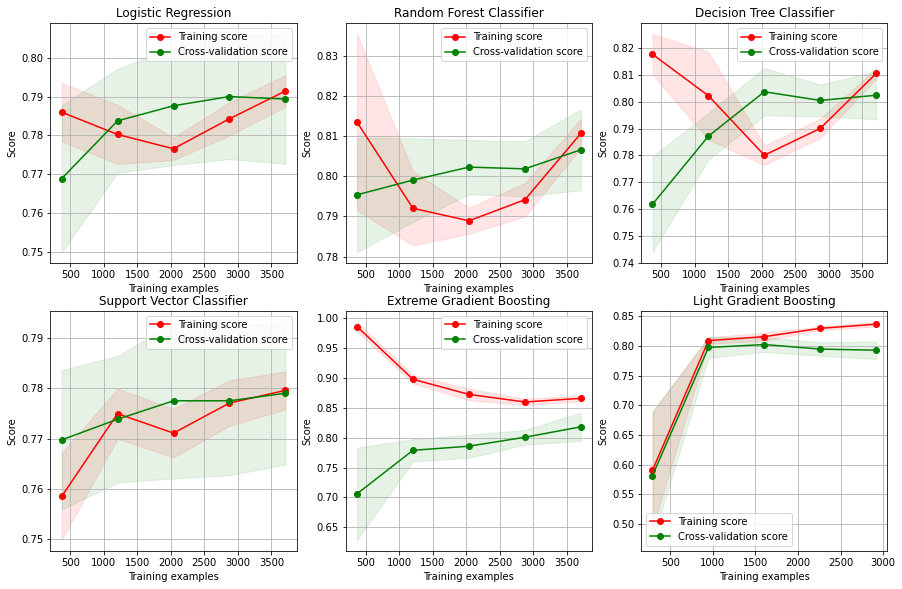

In [32]:
#Variables
n_jobs = 10
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

#Classifiers
log_reg = hyperparameter_tuned_classfier["Logistic Regression"]
svc = hyperparameter_tuned_classfier["Support Vector Classifier"]
decision_tree = hyperparameter_tuned_classfier["Decision Tree"]
RandomForest = hyperparameter_tuned_classfier["RandomForest"]
xgboost = hyperparameter_tuned_classfier["Gradient Boosting"]
lightgbm = lgb

plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plot_learning_curve(log_reg, 'Logistic Regression', X_train_SMOTE, y_train_SMOTE, n_jobs=-1)

plt.subplot(3,3,2)
plot_learning_curve(RandomForest, 'Random Forest Classifier', X_train_SMOTE, y_train_SMOTE, n_jobs=-1)

plt.subplot(3,3,3)
plot_learning_curve(decision_tree, 'Decision Tree Classifier', X_train_SMOTE, y_train_SMOTE, n_jobs=-1)

plt.subplot(3,3,4)
plot_learning_curve(svc, 'Support Vector Classifier', X_train_SMOTE, y_train_SMOTE, n_jobs=-1)

plt.subplot(3,3,5)
plot_learning_curve(xgboost, 'Extreme Gradient Boosting', X_train_SMOTE, y_train_SMOTE, n_jobs=-1)

plt.subplot(3,3,6)
plot_learning_curve(lightgbm, 'Light Gradient Boosting', X_train_stand, y_train, n_jobs=-1)

plt.show()

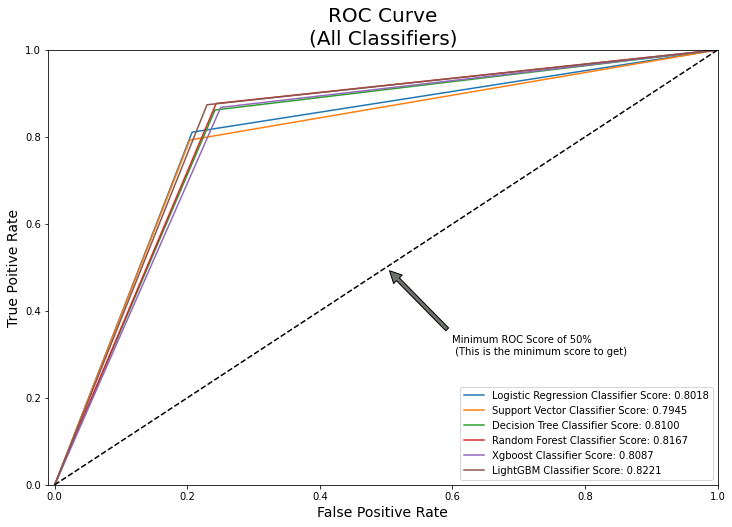

In [40]:
#ROC Curve
'''log_pred = cross_val_predict(log_reg, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5)
tree_pred = cross_val_predict(decision_tree, X_train, y_train, cv=5)
knear_pred = cross_val_predict(knearest, X_train, y_train, cv=5)'''

log_pred = (log_reg.predict_proba(X_test_stand)[:,1] >= 0.5).astype(bool)
svc_pred = (svc._predict_proba_lr(X_test_stand)[:,1] >= 0.5).astype(bool)
tree_pred = decision_tree.predict(X_test_stand)
RandomForeest_pred = RandomForest.predict(X_test_stand)
Xgboost_pred = (xgboost.predict_proba(X_test_stand)[:,1] >= 0.4).astype(bool)
lgb_y_pred = (lgb.predict_proba(X_test_stand[feats],num_iteration=lgb.best_iteration_)[:,1] >= 0.45).astype(bool)

log_fpr, log_tpr, log_threshold = roc_curve(y_test, log_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)
RF_fpr, RF_tpr, RF_threshold = roc_curve(y_test, RandomForeest_pred)
xgboost_fpr, xgboost_tpr, xgboost_threshold = roc_curve(y_test, Xgboost_pred)
lgb_fpr, lgb_tpr, lgb_threshold = roc_curve(y_test, lgb_y_pred)



plt.figure(figsize=(12,8))
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test, log_pred)))
plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_test, svc_pred)))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_test, tree_pred)))
plt.plot(RF_fpr, RF_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_test, RandomForeest_pred)))
plt.plot(xgboost_fpr, xgboost_tpr, label='Xgboost Classifier Score: {:.4f}'.format(roc_auc_score(y_test, Xgboost_pred)))
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM Classifier Score: {:.4f}'.format(roc_auc_score(y_test, lgb_y_pred)))

plt.plot([0,1],[0,1],'k--')
plt.axis([-0.01, 1, 0, 1])

plt.title('ROC Curve\n(All Classifiers)', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Poitive Rate', fontsize=14)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
plt.legend()
plt.show()

In [41]:
labels = ['Non-Default', 'Default']

print('Logistic Regression:')
print(classification_report(y_test, log_pred, target_names=labels))

print('Support Vector Classifier:')
print(classification_report(y_test, svc_pred, target_names=labels))

print('Decision Tree:')
print(classification_report(y_test, tree_pred, target_names=labels))

print('Random Forest Classifier:')
print(classification_report(y_test, RandomForeest_pred, target_names=labels))

print('Extreme Gradient Boosting Classifier:')
print(classification_report(y_test, Xgboost_pred, target_names=labels))

print('Light Gradient Boosting Classifier:')
print(classification_report(y_test, lgb_y_pred, target_names=labels))


Logistic Regression:
              precision    recall  f1-score   support

 Non-Default       0.88      0.79      0.83       579
     Default       0.69      0.81      0.75       333

    accuracy                           0.80       912
   macro avg       0.79      0.80      0.79       912
weighted avg       0.81      0.80      0.80       912

Support Vector Classifier:
              precision    recall  f1-score   support

 Non-Default       0.87      0.80      0.83       579
     Default       0.69      0.79      0.74       333

    accuracy                           0.79       912
   macro avg       0.78      0.79      0.78       912
weighted avg       0.80      0.79      0.80       912

Decision Tree:
              precision    recall  f1-score   support

 Non-Default       0.91      0.76      0.83       579
     Default       0.67      0.86      0.76       333

    accuracy                           0.80       912
   macro avg       0.79      0.81      0.79       912
weighted av

In [35]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[459 120]
 [ 63 270]]
Confusion matrix, without normalization
[[461 118]
 [ 69 264]]
Confusion matrix, without normalization
[[439 140]
 [ 46 287]]
Confusion matrix, without normalization
[[438 141]
 [ 41 292]]
Confusion matrix, without normalization
[[470 109]
 [ 59 274]]
Confusion matrix, without normalization
[[446 133]
 [ 42 291]]
Confusion matrix, without normalization
[[579   0]
 [  0 333]]


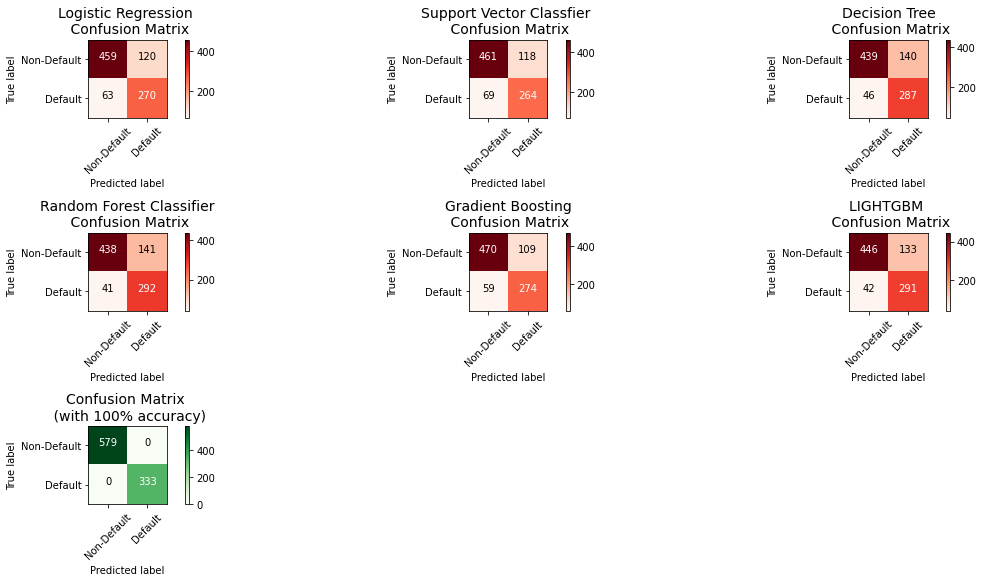

In [39]:
from sklearn.metrics import confusion_matrix
log_reg_cm = confusion_matrix(y_test, log_reg.predict(X_test_stand))
svc_cm = confusion_matrix(y_test, svc.predict(X_test_stand))
dt_cm = confusion_matrix(y_test, decision_tree.predict(X_test_stand))
RF_cm = confusion_matrix(y_test, RandomForest.predict(X_test_stand))
xgboost_cm = confusion_matrix(y_test, (xgboost.predict(X_test_stand)))
lightgbm_cm = confusion_matrix(y_test, (lgb.predict_proba(X_test_stand[feats],num_iteration=lgb.best_iteration_)[:,1] >= 0.45).astype(bool))


actual_cm = confusion_matrix(y_test, y_test)
labels = ['Non-Default', 'Default']


fig = plt.figure(figsize=(16,8))

fig.add_subplot(331)
plot_confusion_matrix(log_reg_cm, labels, title="Logistic Regression \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(332)
plot_confusion_matrix(svc_cm, labels, title="Support Vector Classfier \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(333)
plot_confusion_matrix(dt_cm, labels, title="Decision Tree\n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(334)
plot_confusion_matrix(RF_cm, labels, title="Random Forest Classifier\n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(335)
plot_confusion_matrix(xgboost_cm, labels, title="Gradient Boosting\n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(336)
plot_confusion_matrix(lightgbm_cm, labels, title="LIGHTGBM \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(337)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

plt.show()

In [42]:
#After analyzing all the models. LightGBM  method has given better prediction compared to all the used models.
# Accuracy on test data is more than 80%
# Recall - 87%
# AUC - 82% 